In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np 
import pandas as pd
import os

In [ ]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
import warnings
warnings.filterwarnings('ignore')
%config Completer.use_jedi = False # if autocompletion doesnot work in kaggle notebook | hit tab

In [ ]:
import pandas as pd# importing the dataset 
df_train = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/emotions-dataset-for-nlp/train.txt', header =None, sep =';', names = ['Input','Sentiment'], encoding='utf-8')
df_test = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/emotions-dataset-for-nlp/test.txt', header = None, sep =';', names = ['Input','Sentiment'],encoding='utf-8')
df_val=pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/emotions-dataset-for-nlp/val.txt',header=None,sep=';',names=['Input','Sentiment'],encoding='utf-8')

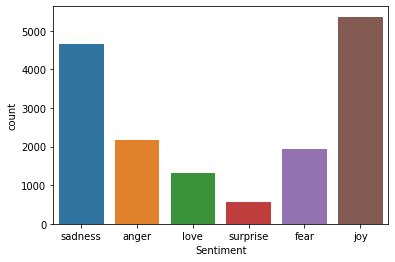

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(df_train.Sentiment)
plt.show()

In [ ]:
!pip install text_hammer 
import text_hammer as th

     |████████████████████████████████| 115 kB 9.4 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [ ]:
%%time
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

CPU times: user 312 µs, sys: 68 µs, total: 380 µs
Wall time: 381 µs


In [ ]:
def text_preprocessing(df,col_name):
    column = col_name
    df[column] = df[column].progress_apply(lambda x:str(x).lower())
    df[column] = df[column].progress_apply(lambda x: th.cont_exp(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_emails(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_html_tags(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_special_chars(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_accented_chars(x))
    df[column] = df[column].progress_apply(lambda x: th.make_base(x)) #ran -> run,
    return(df)

In [ ]:
 #you're -> you are; i'm -> i am

In [ ]:
df_cleaned_train = text_preprocessing(df_train, 'Input')


  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

In [ ]:
df_cleaned_train['Sentiment'] = df_cleaned_train.Sentiment.replace({'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5})
df_test['Sentiment'] = df_test.Sentiment.replace({'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5})
df_val['Sentiment'] = df_val.Sentiment.replace({'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5})

In [ ]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(df_cleaned_train.Sentiment.values)
y_test = to_categorical(df_test.Sentiment.values)
y_val = to_categorical(df_val.Sentiment.values)

In [ ]:
from keras.preprocessing.text import Tokenizer
max_words = 10000
tokenizer=Tokenizer(max_words,lower=True)
df_total = pd.concat([df_cleaned_train['Input'], df_test.Input], axis = 0)
tokenizer.fit_on_texts(df_total)

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
X_train=tokenizer.texts_to_sequences(df_cleaned_train['Input']) # this converts texts into some numeric sequences 
X_train_pad=pad_sequences(X_train,maxlen=300,padding='post') # this makes the length of all numeric sequences equal 
X_test = tokenizer.texts_to_sequences(df_test.Input)
X_test_pad = pad_sequences(X_test, maxlen = 300, padding = 'post')
X_val = tokenizer.texts_to_sequences(df_val.Input)
X_val_pad = pad_sequences(X_val, maxlen = 300, padding = 'post')

In [ ]:
!pip install gensim

In [ ]:
import gensim.downloader as api
glove_gensim  = api.load('glove-wiki-gigaword-100')

[==================================================] 100.0% 128.1/128.1MB downloaded


In [ ]:
vector_size = 100
gensim_weight_matrix = np.zeros((max_words ,vector_size))
gensim_weight_matrix.shape

(10000, 100)

In [ ]:
for word, index in tokenizer.word_index.items():
    if index < max_words: # since index starts with zero 
        if word in glove_gensim.wv.vocab:
            gensim_weight_matrix[index] = glove_gensim[word]
        else:
            gensim_weight_matrix[index] = np.zeros(100)

In [ ]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, LSTM, Embedding,Bidirectional
import tensorflow
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.layers import Dropout

In [ ]:
EMBEDDING_DIM = 100
class_num = 6
model = Sequential()
model.add(Embedding(input_dim = max_words,
 output_dim = EMBEDDING_DIM,
 input_length= X_train_pad.shape[1],
 weights = [gensim_weight_matrix],trainable = False))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(100,return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(200,return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(100,return_sequences=False)))
model.add(Dense(class_num, activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam',metrics = 'accuracy')

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
mc = ModelCheckpoint('./model.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True, save_weights_only=True)

In [ ]:
history_embedding = model.fit(X_train_pad, y_train, 
                                epochs = 25, batch_size = 120, 
                                validation_data=(X_val_pad, y_val),
                                verbose = 1, callbacks= [es, mc])

Epoch 1/25
134/134 [==============================] - ETA: 0s - loss: 1.4328 - accuracy: 0.4430
Epoch 00001: val_accuracy improved from -inf to 0.58100, saving model to ./model.h5
134/134 [==============================] - 1045s 8s/step - loss: 1.4328 - accuracy: 0.4430 - val_loss: 1.2241 - val_accuracy: 0.5810
Epoch 2/25
134/134 [==============================] - ETA: 0s - loss: 1.1023 - accuracy: 0.5957
Epoch 00002: val_accuracy improved from 0.58100 to 0.68650, saving model to ./model.h5
134/134 [==============================] - 1002s 7s/step - loss: 1.1023 - accuracy: 0.5957 - val_loss: 0.8883 - val_accuracy: 0.6865
Epoch 3/25
134/134 [==============================] - ETA: 0s - loss: 0.8126 - accuracy: 0.7048
Epoch 00003: val_accuracy improved from 0.68650 to 0.77900, saving model to ./model.h5
134/134 [==============================] - 996s 7s/step - loss: 0.8126 - accuracy: 0.7048 - val_loss: 0.6033 - val_accuracy: 0.7790
Epoch 4/25
134/134 [==============================] - ET

In [ ]:
fer_json = model.to_json()
with open("/content/gdrive/My Drive/Colab Notebooks/emotions-dataset-for-nlp/RNN/fer.json", "w") as json_file:
    json_file.write(fer_json)
model.save_weights("/content/gdrive/My Drive/Colab Notebooks/emotions-dataset-for-nlp/RNN/fer.h5")

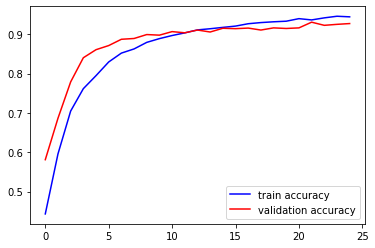

In [ ]:
plt.plot(history_embedding.history['accuracy'],c='b',label='train accuracy')
plt.plot(history_embedding.history['val_accuracy'],c='r',label='validation accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
y_pred =   np.argmax(model.predict(X_test_pad), axis  =  1)
y_true = np.argmax(y_test, axis = 1)
from sklearn import metrics
print(metrics.classification_report(y_pred, y_true))


              precision    recall  f1-score   support

           0       0.94      0.94      0.94       695
           1       0.91      0.91      0.91       275
           2       0.86      0.82      0.84       165
           3       0.94      0.95      0.95       570
           4       0.93      0.88      0.90       238
           5       0.70      0.81      0.75        57

    accuracy                           0.92      2000
   macro avg       0.88      0.88      0.88      2000
weighted avg       0.92      0.92      0.92      2000

